# Introduction

According to the World Health Organization (WHO) stroke is the **second** leading cause of death globally, responsible for approximately 11% of total deaths. Stroke happens when blood supply to part of the brain is blocked or reduced. This causes brain cells to die within minutes as they did not receive the oxygen and nutrients they critically need to survive.

Many factors can **increase the risk of stroke** such as:
- being overweight or obese
- high blood pressure
- cigarette smoking or secondhand smore exposure
- diabetes
- age; people age 55 or older have a higher risks
- gender; men have a higher risk of stroke than women

## Objective

To visualise the relationship between various risk factors with the probability of getting stroke and design a predictive model to determine whether a patient is likely to get stroke based on risk factors like gender, age, various diseases, and smoking status. 

The target variable is "stroke": 1 if the patient had a stroke or 0 if patient do not have a stroke.

Each row in the data provides relevant information about the patient.

## Data description

Below is the information about each feature available in the dataset:

<ol>
    <li>id: unique identifier</li>
    <li>gender: "Male", "Female" or "Other"</li>
    <li>age: age of the patient</li>
    <li>hypertension: 0 if the patient doesn't have hypertension, 1 if the patient has hypertension</li>
    <li>heart_disease: 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease</li>
    <li>ever_married: "No" or "Yes"</li>
    <li>work_type: "children", "Govt_jov", "Never_worked", "Private" or "Self-employed"</li>
    <li>Residence_type: "Rural" or "Urban"</li>
    <li>avg_glucose_level: average glucose level in blood</li>
    <li>bmi: body mass index</li>
    <li>smoking_status: "formerly smoked", "never smoked", "smokes" or "Unknown"*</li>
    <li>stroke: 1 if the patient had a stroke or 0 if not</li>
</ol>

*Note: "Unknown" in smoking_status means that the information is unavailable for this patient

## Import packages

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#filter warnings
import warnings
warnings.filterwarnings("ignore")

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from sklearn.preprocessing import StandardScaler 

#import libraries for creating model
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

#import libraries for evaluating model performance
from sklearn.metrics import accuracy_score, roc_curve, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV, cross_val_score, RandomizedSearchCV

## Load data into Pandas Dataframe

In [2]:
df = pd.read_csv('healthcare-dataset-stroke-data.csv')

In [3]:
#view first 5 rows of the data
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [4]:
#how big is the data? number of rows, features, and their types

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


The stroke dataset has 5110 rows (5110 patients) and 12 columns ie features. The last column 'stroke' is the target variable. Other features are the risk factors associated with getting stroke. The id column is the unique identification of each patients which we can use for detecting duplicate rows but for building machine learning, we have to remove this column later on. 

In [5]:
# number of missing values
# only column 'bmi' has missing values. 

df.isnull().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [6]:
# percentage of the missing values
# the % of missing values in bmi column is low; only 3.9%

NAN = [(col, df[col].isna().mean()*100) for col in df]
NAN = pd.DataFrame(NAN, columns=["column_name", "percentage"])
NAN

,column_name,percentage
0,id,0.000000
1,gender,0.000000
2,age,0.000000
3,hypertension,0.000000
4,heart_disease,0.000000
5,ever_married,0.000000
6,work_type,0.000000
7,Residence_type,0.000000
8,avg_glucose_level,0.000000
9,bmi,3.933464


<AxesSubplot:>

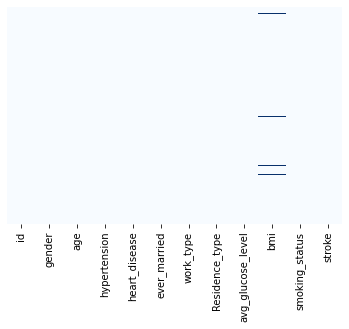

In [7]:
#view the null values in the form of heatmap
sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap="Blues")

- is the data types accurate? if not, fix them
- the data types are accurate. for modelling purposes, we will convert the categorical/object column into numerical using dummy variables later on

In [8]:
#check data for duplicate rows
def check_duplicate(d,c):
    if len(d[c])>len(set(d[c])):
        print('Data has duplicate')
    else:
        print('Data does not have duplicate')

check_duplicate(df, 'id')

Data does not have duplicate


- our data do not have duplicate
- if have duplicate, to remove duplicated rows ==> df=df.drop_duplicates()

In [9]:
#Drop the id column as it is not useful for building model
df.drop(['id'], axis=1, inplace=True)

In [10]:
#Check if id column has been removed
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


## Exploratory Data Analysis (EDA)

what you can do with EDA:
- familiarise with different features of the data
- learn about individual features and their mutual relationship or lack of
- check and validate data for anomalies, outliers,missing values
- extract useful insights 

### Explore target variable

In [11]:
#for visualisation, first separate categorical and numerical variables

#convert all categorical data to proper data type ie 'category'
categorical_columns = ['stroke','gender', 'hypertension', 'heart_disease','ever_married', 'work_type', 'Residence_type', 'smoking_status']
df[categorical_columns] = df[categorical_columns].apply(lambda x: x.astype('category'))

df_cat = df.select_dtypes(include=['category'])
df_num = df.select_dtypes(exclude=['category'])

In [12]:
#check
df.dtypes

gender               category
age                   float64
hypertension         category
heart_disease        category
ever_married         category
work_type            category
Residence_type       category
avg_glucose_level     float64
bmi                   float64
smoking_status       category
stroke               category
dtype: object

In [13]:
df_cat

,gender,hypertension,heart_disease,ever_married,work_type,Residence_type,smoking_status,stroke
0,Male,0,1,Yes,Private,Urban,formerly smoked,1
1,Female,0,0,Yes,Self-employed,Rural,never smoked,1
2,Male,0,1,Yes,Private,Rural,never smoked,1
3,Female,0,0,Yes,Private,Urban,smokes,1
4,Female,1,0,Yes,Self-employed,Rural,never smoked,1
...,...,...,...,...,...,...,...,...
5105,Female,1,0,Yes,Private,Urban,never smoked,0
5106,Female,0,0,Yes,Self-employed,Urban,never smoked,0
5107,Female,0,0,Yes,Self-employed,Rural,never smoked,0
5108,Male,0,0,Yes,Private,Rural,formerly smoked,0


In [14]:
df[categorical_columns]

,stroke,gender,hypertension,heart_disease,ever_married,work_type,Residence_type,smoking_status
0,1,Male,0,1,Yes,Private,Urban,formerly smoked
1,1,Female,0,0,Yes,Self-employed,Rural,never smoked
2,1,Male,0,1,Yes,Private,Rural,never smoked
3,1,Female,0,0,Yes,Private,Urban,smokes
4,1,Female,1,0,Yes,Self-employed,Rural,never smoked
...,...,...,...,...,...,...,...,...
5105,0,Female,1,0,Yes,Private,Urban,never smoked
5106,0,Female,0,0,Yes,Self-employed,Urban,never smoked
5107,0,Female,0,0,Yes,Self-employed,Rural,never smoked
5108,0,Male,0,0,Yes,Private,Rural,formerly smoked


In [15]:
df_num

,age,avg_glucose_level,bmi
0,67.0,228.69,36.6
1,61.0,202.21,NaN
2,80.0,105.92,32.5
3,49.0,171.23,34.4
4,79.0,174.12,24.0
...,...,...,...
5105,80.0,83.75,NaN
5106,81.0,125.20,40.0
5107,35.0,82.99,30.6
5108,51.0,166.29,25.6


### Univariate analysis of categorical variables

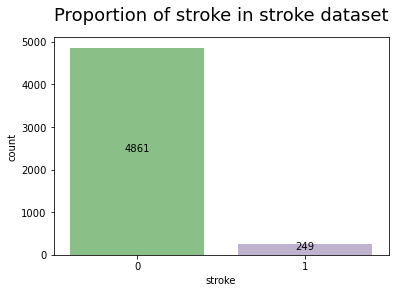

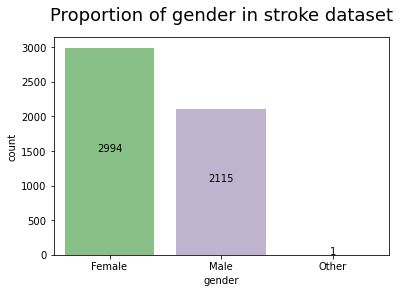

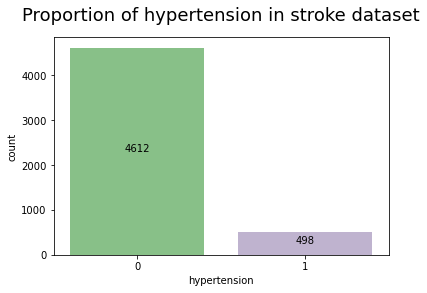

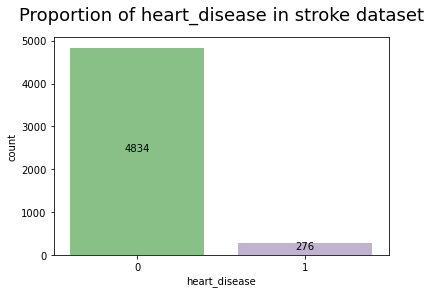

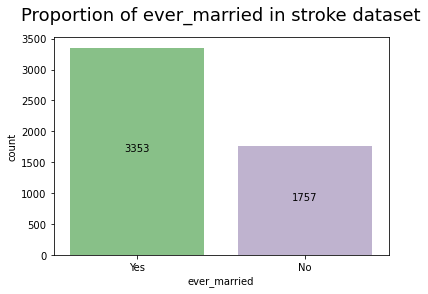

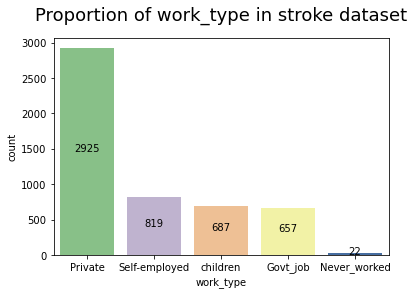

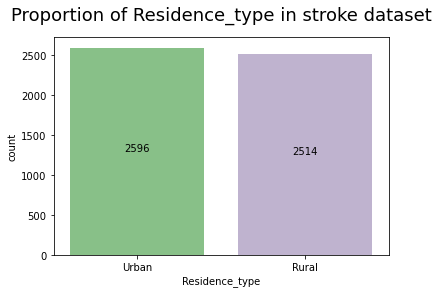

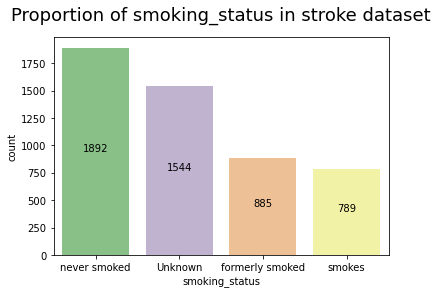

In [16]:
for i,x in enumerate(df[categorical_columns]):    
    plt.figure(i)
    #print(df[x].value_counts())
    ax = sns.countplot(x = x, data = df, order = df[x].value_counts().index, palette = 'Accent')
    ax.text(0.5, 1.1,"Proportion of {} in stroke dataset".format(x), horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=18, fontfamily='sans-serif')
    
    #display the counts in the middle of the bar. adjust height - 0.1 to display on the top
    i=0
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2., height/2, df[x].value_counts()[i],ha="center")
        i += 1

### Insights

- the number of females in our dataset is higher than males and other
- ratio around 2:1 for being ever married
- most of the patients in our dataset worked in private sectors
- residence type is balanced between urban and rural
- for smoking_status, a lot of the patients has never smoked before in their life.
- **for target variable 'stroke', our dataset is imbalanced. Proportion of patients that do not have a stroke is much higher than patients with stroke.**

### Solutions

- upsampling the dataset using SMOTE

### Explore relationship between categorical & target variables

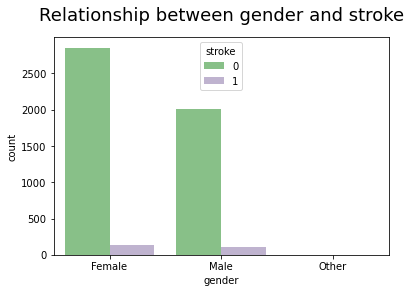

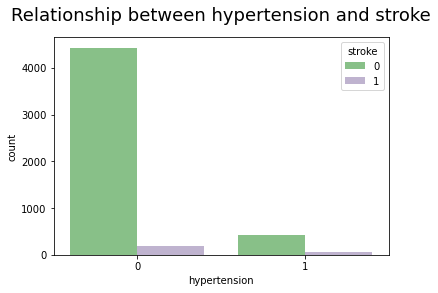

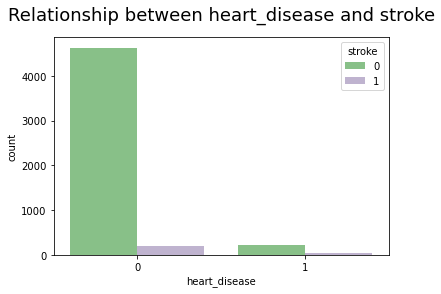

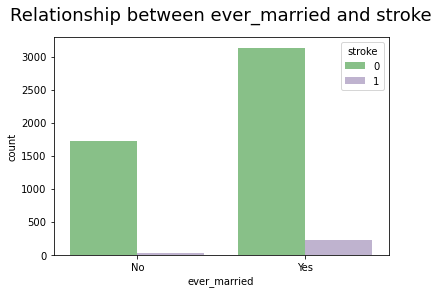

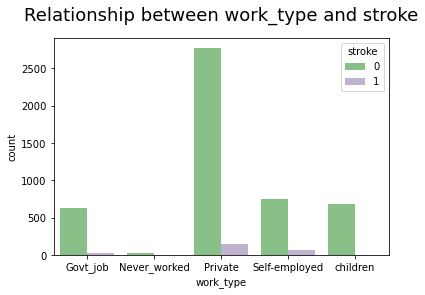

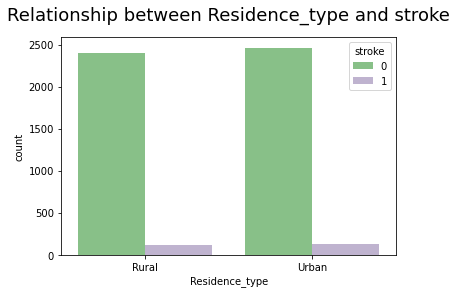

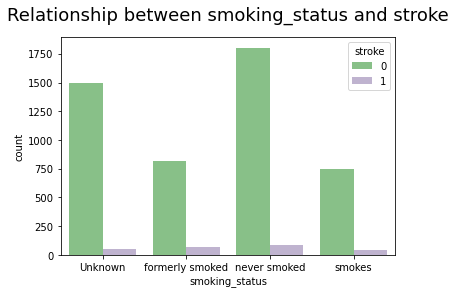

In [17]:
# another method to exclude a column from the for loop
# df.loc[:, ~df.columns.isin(['stroke'])]

for i in (df[categorical_columns].loc[:, df[categorical_columns].columns != 'stroke']):    
    plt.figure(i)
    ax = sns.countplot(x = i, data = df, hue= 'stroke', palette = 'Accent')
    ax.text(0.5, 1.1,"Relationship between {} and stroke".format(i), horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=18, fontfamily='sans-serif')

#### Insights

- as compared to stroke '0', the amount of patients who has stroke in each of the features is low because our dataset for target variable is imbalanced.

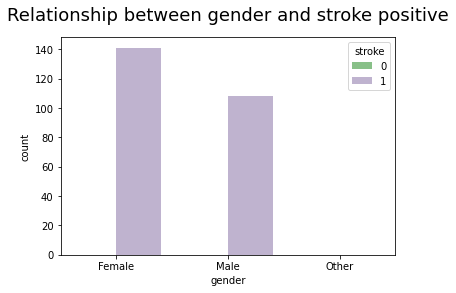

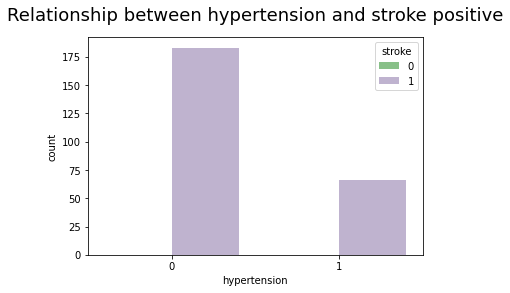

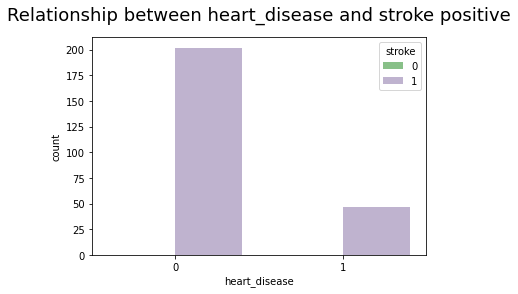

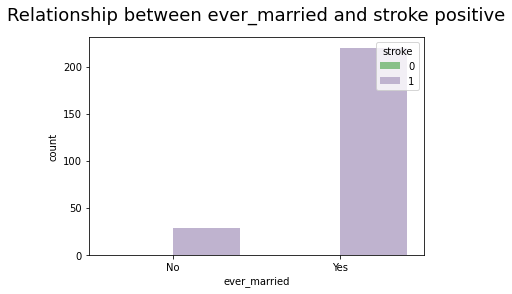

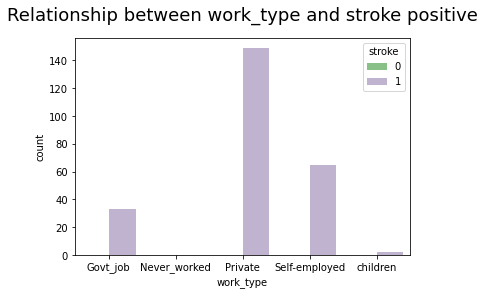

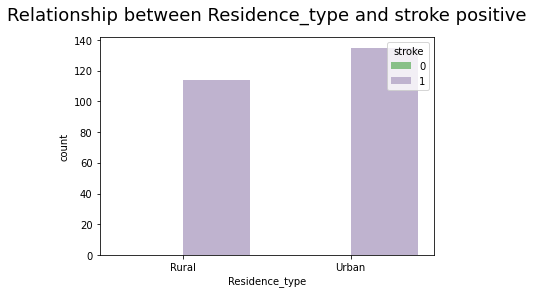

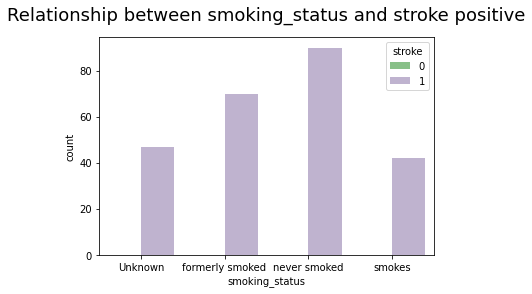

In [18]:
#to get better look at stroke = 1 proportion in different features

stroke_positive = df[df['stroke'] == 1]

for i in (df[categorical_columns].loc[:, df[categorical_columns].columns != 'stroke']):    
    plt.figure(i)
    ax = sns.countplot(x = i, data = stroke_positive, hue= 'stroke', palette = 'Accent')
    ax.text(0.5, 1.1,"Relationship between {} and stroke positive".format(i), horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=18, fontfamily='sans-serif')

### Findings:
- both female and males has similar probability of getting stroke.Same goes to residence type. So, gender and residence_type are not factors that determine whether one gets a stroke or not. 
- patients with no hypertension and no heart_disease are more likely to get stroke which is surprising because having hypertension and heart disease are said to increase risk of getting stroke.This might be due to our imbalanced dataset. 
- patients working in private sectors have the highest number of stroke. This perhaps could be because of occupational stress. Studies/surveys have found that government employees are healthier than private sectors and one of the reasons could be because only small percentage of private sectors employees receive health insurance whereas govt employees all receive health insurance. Lack of health insurance lead to financial insecurity.
- number of stroke in people who never worked and children is negligible. 
- another surprising findings is people who never smoked has the highest number of stroke and the lowest is people who smokes. 


### Explore numerical variables

array([[<AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'avg_glucose_level'}>],
       [<AxesSubplot:title={'center':'bmi'}>, <AxesSubplot:>]],
      dtype=object)

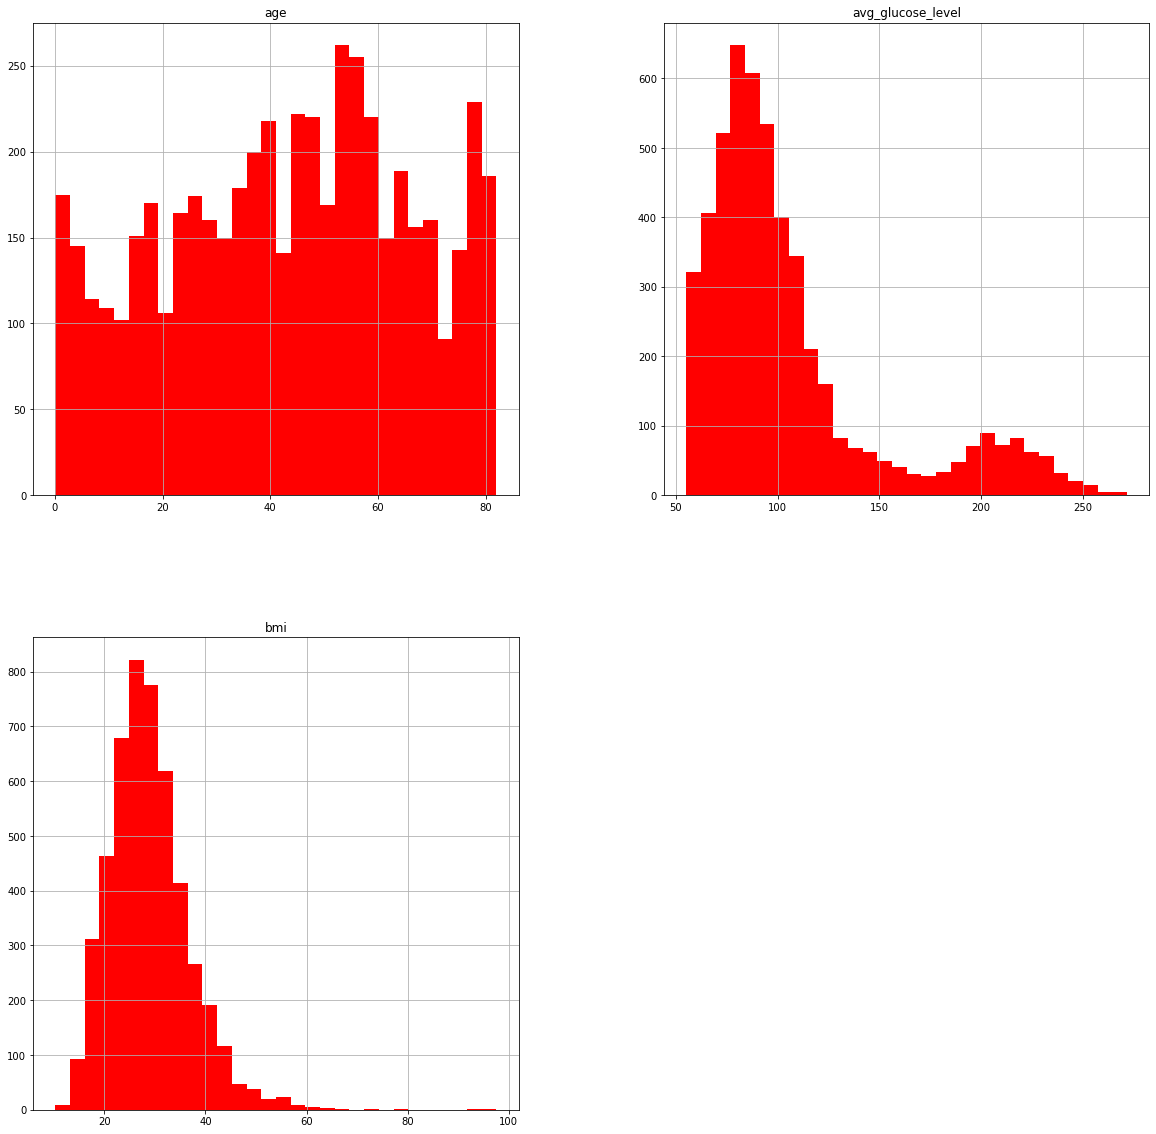

In [19]:
# histogram
df_num.hist(bins=30, figsize=(20, 20), color='r')

In [20]:
len(df_num.columns)

3

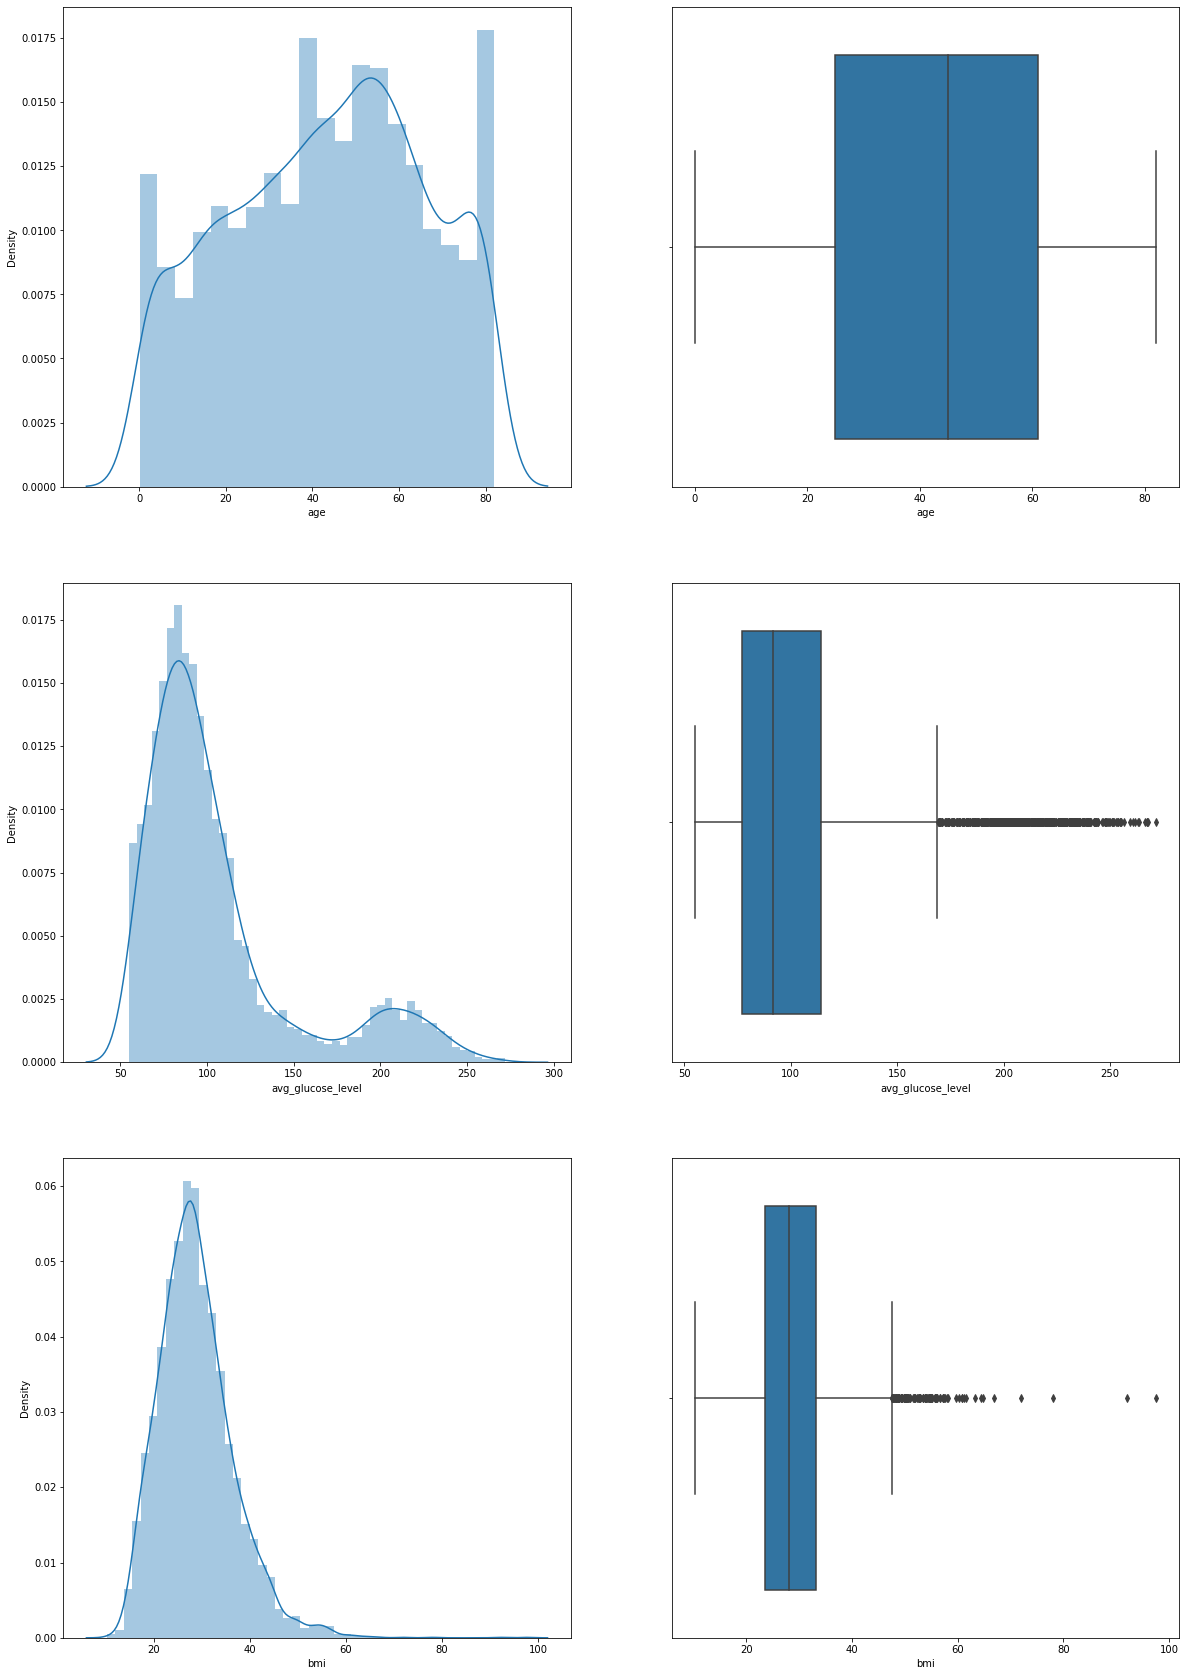

In [21]:
#distribution plot and boxplot

fig, ax = plt.subplots(nrows = len(df_num.columns), ncols = 2, figsize = (20, 30))
for i in range(len(df_num.columns)):
    sns.distplot(df[df_num.columns[i]], ax = ax[i,0])
    sns.boxplot(df[df_num.columns[i]], ax = ax[i,1])

In [22]:
# skewness
# If less than -1 or greater than 1, the distribution is highly skewed. 
# If between -1 and -0.5 or between 0.5 and 1, the distribution is moderately skewed. 
# If between -0.5 and 0.5, the distribution is approximately symmetric
df_num.skew()

age                 -0.137059
avg_glucose_level    1.572284
bmi                  1.055340
dtype: float64

- from the skewness value above, age is approximately symmetric
- bmi and avg glucose level is greater than 1 meaning highly skewed
- we need to treat the outliers
- There are many techniques of handling these extreme values, one of which is quantile based capping or flooring. Since it is right skewed, we can do the capping for the higher values.

In [23]:
df.describe()

,age,avg_glucose_level,bmi
count,5110.000000,5110.000000,4909.000000
mean,43.226614,106.147677,28.893237
std,22.612647,45.283560,7.854067
min,0.080000,55.120000,10.300000
25%,25.000000,77.245000,23.500000
50%,45.000000,91.885000,28.100000
75%,61.000000,114.090000,33.100000
max,82.000000,271.740000,97.600000


stroke
0    4861
1     249
dtype: int64


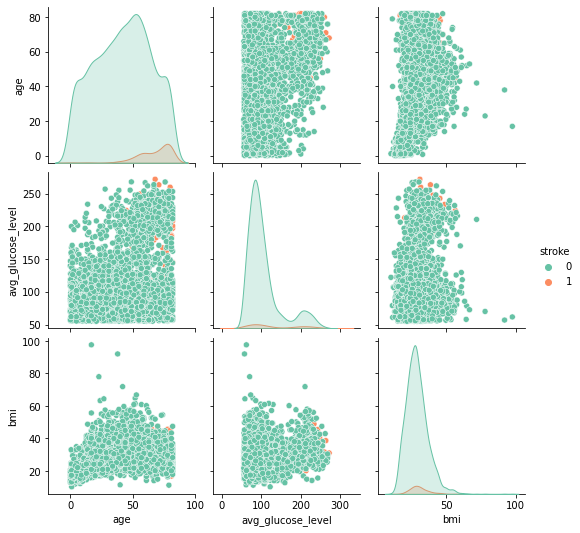

In [24]:
# pairplot

print(df.groupby('stroke').size())
sns.pairplot(df, kind="scatter", hue="stroke", palette="Set2")
plt.show()

### Insights

#### Proportions of numerical variables in the dataset
- age seems to be distributed normally. most of the patients are around 45 years old. 
- avg glucose level skewed to the right/positive skew. most of the patients have avg glucose level around 90. many outliers.
- avg glucose level skewed to the right/positive skew. most of the patients have bmi around 28. many outliers.

#### Relationship between numerical variables and target variable (refer pairplot)
- older people are more likely to get stroke; people aged between 50-80
- high avg glucose level more likely to get stroke; 150-250
- high bmi more likely to get stroke
- ie when age, glucose level and/or bmi are on the higher side, risk of getting stroke also high.



### Data preprocessing - Handling missing values

In [25]:
df.isnull().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [26]:
#impute missing values in bmi using median (because data is skewed)
df.loc[(df["bmi"].isnull() == True), 'bmi'] = df['bmi'].median()

# check null values after imputing
df.isnull().sum()

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

### Handling outliers (feature engineering)

In [27]:
# because bmi and avg_glucose_level is highly skewed, we will treat the outliers in these columns.
# first, lets detect the outliers in bmi and avg_glucose_level

skewed_columns = df[['bmi', 'avg_glucose_level']]

for c in skewed_columns:
    #getting upper lower quartile values
    q25,q75=np.percentile(skewed_columns[c],25),np.percentile(skewed_columns[c],75)
    IQR=q75-q25
    Threshold=IQR*1.5
    lower,upper=q25-Threshold,q75+Threshold
    Outliers=[i for i in skewed_columns[c] if i < lower or i > upper]
    print('{} Total Number of outliers in {} : {}'.format('\033[1m',c,len(Outliers)))
    print('\n')

 Total Number of outliers in bmi : 126


 Total Number of outliers in avg_glucose_level : 627




In [28]:
#do capping for the higher values since bmi and glucose is positively skewed

#for bmi 
ninety_quantile = df['bmi'].quantile(0.90) #the 90th quantile
df["bmi"] = np.where(df["bmi"] > ninety_quantile, ninety_quantile, df['bmi']) #the capping
print(df['bmi'].skew()) #print the skew after capping

-0.008841610185962617


In [29]:
#for avg_glucose_level
eightyfive_quantile = df['avg_glucose_level'].quantile(0.85) #the 85th quantile
df["avg_glucose_level"] = np.where(df["avg_glucose_level"] > eightyfive_quantile, eightyfive_quantile, df['avg_glucose_level']) #the capping
print(df['avg_glucose_level'].skew()) #print the skew after capping


0.5331968144379452


In [30]:
# check the outliers in bmi and avg_glucose_level after capping

skewed_columns = df[['bmi', 'avg_glucose_level']]

for c in skewed_columns:
    #getting upper lower quartile values
    q25,q75=np.percentile(skewed_columns[c],25),np.percentile(skewed_columns[c],75)
    IQR=q75-q25
    Threshold=IQR*1.5
    lower,upper=q25-Threshold,q75+Threshold
    Outliers=[i for i in skewed_columns[c] if i < lower or i > upper]
    print('{} Total Number of outliers in {} after capping : {}'.format('\033[1m',c,len(Outliers)))
    print('\n')

 Total Number of outliers in bmi after capping : 1


 Total Number of outliers in avg_glucose_level after capping : 0




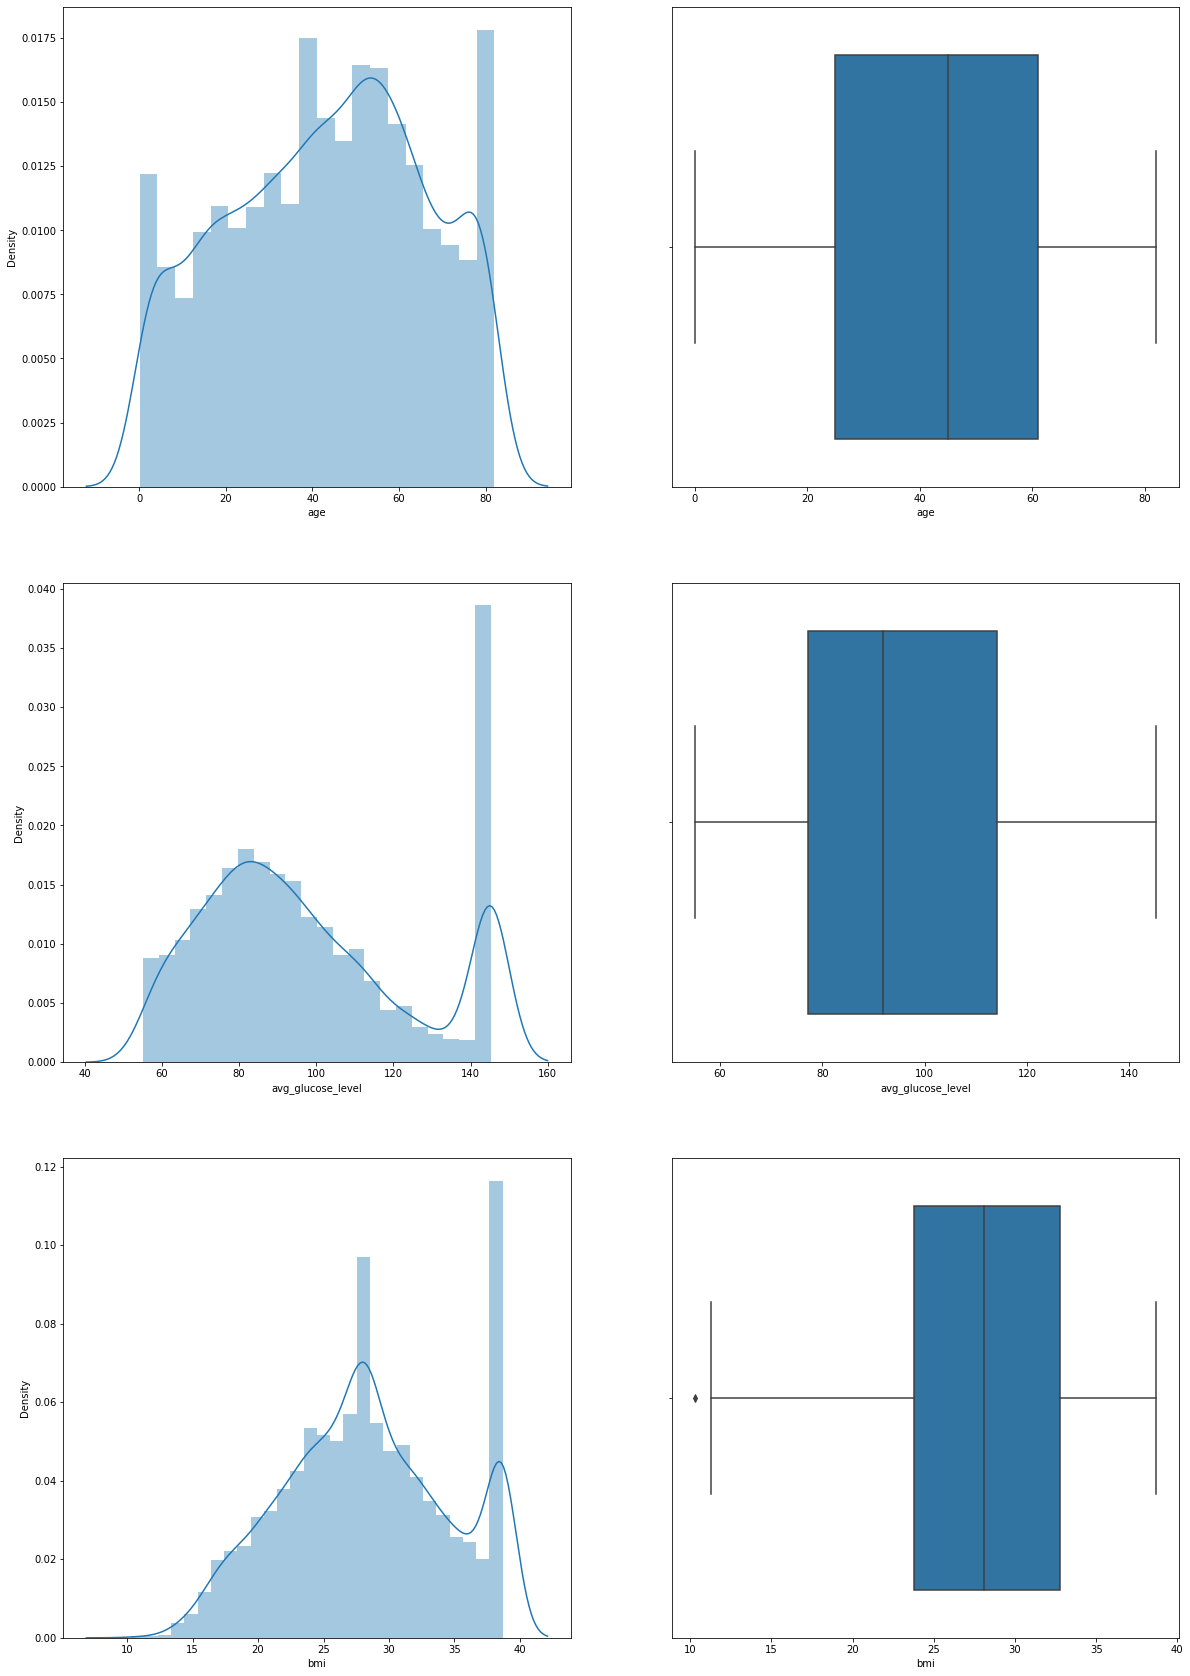

In [31]:
#visualise after capping

fig, ax = plt.subplots(nrows = len(df_num.columns), ncols = 2, figsize = (20, 30))
for i in range(len(df_num.columns)):
    sns.distplot(df[df_num.columns[i]], ax = ax[i,0])
    sns.boxplot(df[df_num.columns[i]], ax = ax[i,1])

### Explore Correlation between Numerical Variables

- highly correlated features (can set the threshold percentage) 
- if correlation between two features is higher than the threshold, can safely remove only one of them

<AxesSubplot:>

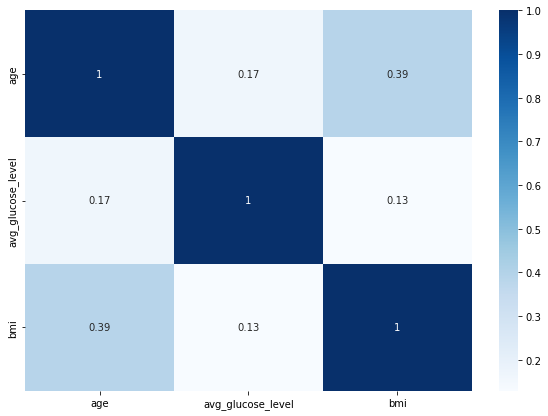

In [32]:
correlation = df.corr()
f, ax = plt.subplots(figsize = (10,7))
sns.heatmap(correlation, annot=True, cmap='Blues')

#none of the variables are highly correlated

In [33]:
df_cat.columns

Index(['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type',
       'Residence_type', 'smoking_status', 'stroke'],
      dtype='object')

### Data PreProcessing - dummy variables

In [34]:
#create dummy variables for categorical data except target 
X_cat = df[['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type',
       'Residence_type', 'smoking_status']]
X_cat = pd.get_dummies(X_cat, drop_first=True)

#concat dummy cat columns with numerical variable
X_all = pd.concat([X_cat, df_num], axis=1)
X_all.head()

,gender_Male,gender_Other,hypertension_1,heart_disease_1,ever_married_Yes,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,age,avg_glucose_level,bmi
0,1,0,0,1,1,0,1,0,0,1,1,0,0,67.0,228.69,36.6
1,0,0,0,0,1,0,0,1,0,0,0,1,0,61.0,202.21,28.1
2,1,0,0,1,1,0,1,0,0,0,0,1,0,80.0,105.92,32.5
3,0,0,0,0,1,0,1,0,0,1,0,0,1,49.0,171.23,34.4
4,0,0,1,0,1,0,0,1,0,0,0,1,0,79.0,174.12,24.0


<AxesSubplot:>

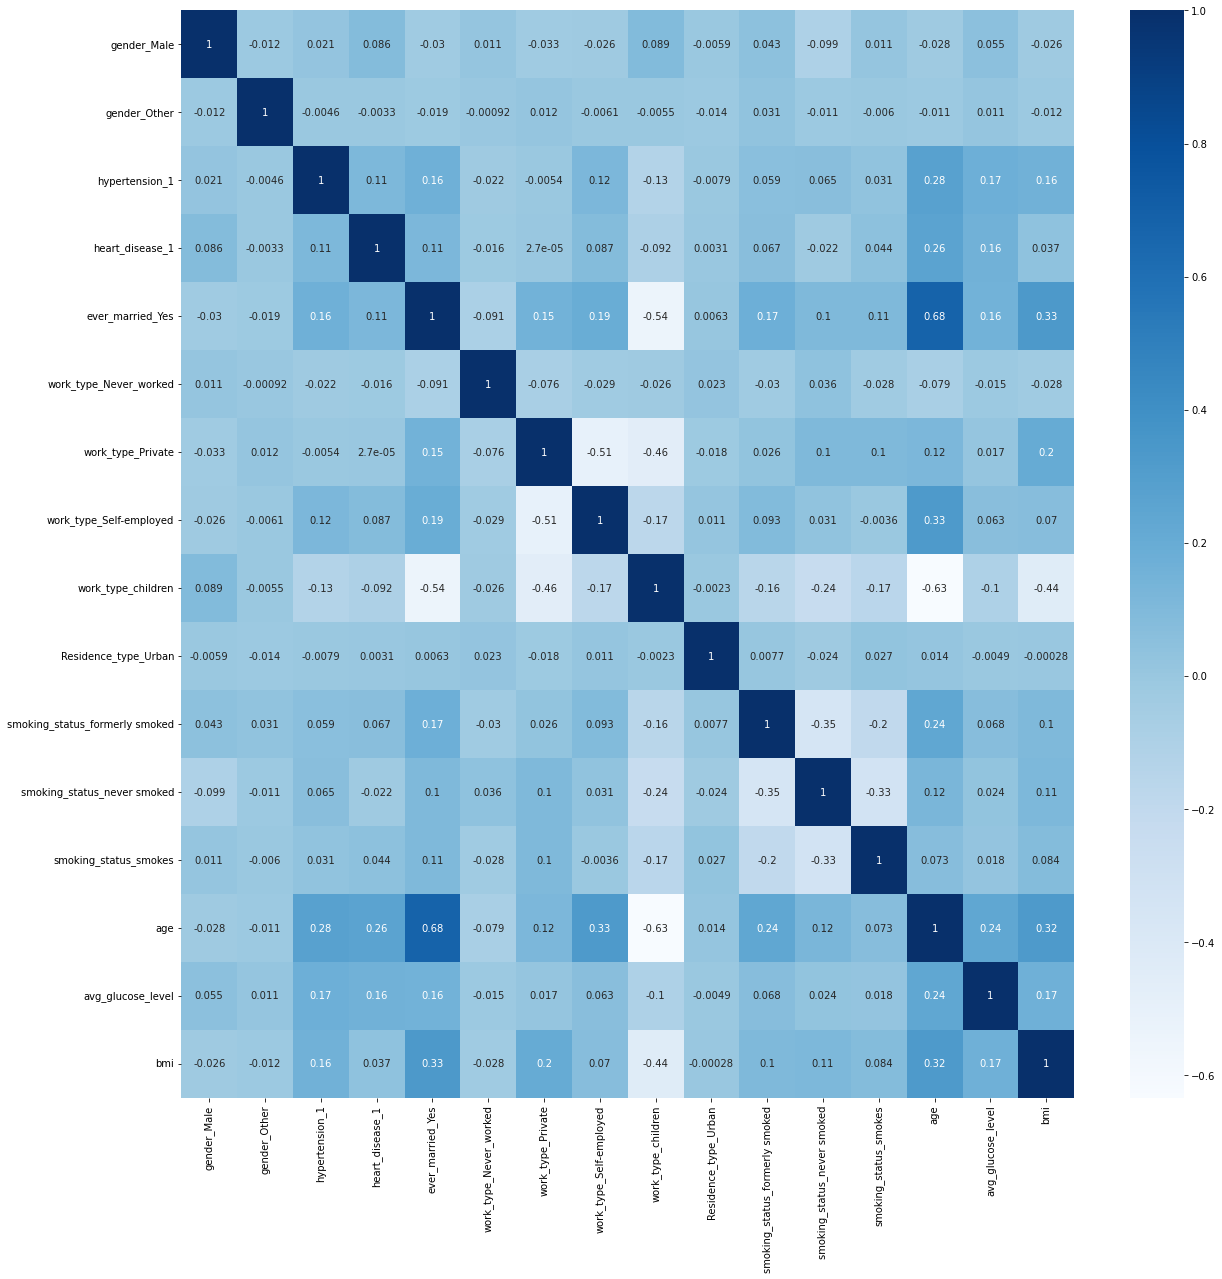

In [35]:
correlation = X_all.corr()
f, ax = plt.subplots(figsize = (20,20))
sns.heatmap(correlation, annot=True, cmap='Blues')

#no features are highly correlated

### Split data into train and test set

In [36]:
X = X_all
y = df['stroke']  

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=42, stratify=y)

In [37]:
X

,gender_Male,gender_Other,hypertension_1,heart_disease_1,ever_married_Yes,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,age,avg_glucose_level,bmi
0,1,0,0,1,1,0,1,0,0,1,1,0,0,67.0,228.69,36.6
1,0,0,0,0,1,0,0,1,0,0,0,1,0,61.0,202.21,28.1
2,1,0,0,1,1,0,1,0,0,0,0,1,0,80.0,105.92,32.5
3,0,0,0,0,1,0,1,0,0,1,0,0,1,49.0,171.23,34.4
4,0,0,1,0,1,0,0,1,0,0,0,1,0,79.0,174.12,24.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5105,0,0,1,0,1,0,1,0,0,1,0,1,0,80.0,83.75,28.1
5106,0,0,0,0,1,0,0,1,0,1,0,1,0,81.0,125.20,40.0
5107,0,0,0,0,1,0,0,1,0,0,0,1,0,35.0,82.99,30.6
5108,1,0,0,0,1,0,1,0,0,0,1,0,0,51.0,166.29,25.6


In [38]:
y

0       1
1       1
2       1
3       1
4       1
       ..
5105    0
5106    0
5107    0
5108    0
5109    0
Name: stroke, Length: 5110, dtype: category
Categories (2, int64): [0, 1]

In [39]:
#check shape of X_train
X_train.shape

(3832, 16)

In [40]:
#check shape of X_test
X_test.shape

(1278, 16)

## Model creation


- we will use 5 classification models = logistic regression, decision tree, random forest, SVC and KNN
- Since we have a large class imbalance in our data, we will do oversampling using SMOTE.
- We will do SMOTE and scaling within a pipeline to ensure that our sampling techniques don’t have data leakage.

In [41]:
# !pip install imbalanced-learn

#import packages, instead of using scikit learn's pipeline, we import from imblearn
from imblearn.pipeline import Pipeline
from imblearn import over_sampling
from imblearn.over_sampling import SMOTE


#logistic regression
pipe_logr = Pipeline(steps = [('smote', SMOTE(random_state = 42)), 
                      ('standardscaler', StandardScaler()),
                      ('logisticregression', LogisticRegression())])

#dt
pipe_dt = Pipeline(steps = [('smote', SMOTE(random_state = 42)), 
                      ('standardscaler', StandardScaler()),
                      ('decisiontree', DecisionTreeClassifier())])

#rf
pipe_rf = Pipeline(steps = [('smote', SMOTE(random_state = 42)), 
                      ('standardscaler', StandardScaler()),
                      ('randomforest', RandomForestClassifier())])

#svm
pipe_svm = Pipeline(steps = [('smote', SMOTE(random_state = 42)), 
                      ('standardscaler', StandardScaler()),
                      ('svm', SVC())])
#knn
pipe_knn = Pipeline(steps = [('smote', SMOTE(random_state = 42)), 
                      ('standardscaler', StandardScaler()),
                      ('knn', KNeighborsClassifier())])

In [42]:
# Model validation via cross-validation

print('*******logistic regression*******')
A_scores_logr = cross_val_score(pipe_logr, X_train, y_train, cv=5)
A_mean_logr = np.mean(A_scores_logr)
print('Mean of accuracy: {}'.format(A_mean_logr))

P_scores_logr=cross_val_score(pipe_logr, X_train, y_train, cv=5, scoring='precision_macro')
P_mean_logr=np.mean(P_scores_logr)
print('Mean of precision: {}'.format(P_mean_logr))

R_scores_logr=cross_val_score(pipe_logr, X_train, y_train, cv=5, scoring='recall_macro')
R_mean_logr=np.mean(R_scores_logr)
print('Mean of recall: {}'.format(R_mean_logr))

F1_scores_logr=cross_val_score(pipe_logr, X_train, y_train, cv=5, scoring='f1_macro')
F1_mean_logr=np.mean(F1_scores_logr)
print('Mean of F1: {}'.format(F1_mean_logr))

*******logistic regression*******
Mean of accuracy: 0.8400339051133404
Mean of precision: 0.5374388663665316
Mean of recall: 0.5985639635737101
Mean of F1: 0.5398358579838416


In [43]:
# Model validation via cross-validation

print('*******decision tree*******')
A_scores_dt = cross_val_score(pipe_dt, X_train, y_train, cv=5)
A_mean_dt = np.mean(A_scores_dt)
print('Mean of accuracy: {}'.format(A_mean_dt))

P_scores_dt=cross_val_score(pipe_dt, X_train, y_train, cv=5, scoring='precision_macro')
P_mean_dt=np.mean(P_scores_dt)
print('Mean of precision: {}'.format(P_mean_dt))

R_scores_dt=cross_val_score(pipe_dt, X_train, y_train, cv=5, scoring='recall_macro')
R_mean_dt=np.mean(R_scores_dt)
print('Mean of recall: {}'.format(R_mean_dt))

F1_scores_dt=cross_val_score(pipe_dt, X_train, y_train, cv=5, scoring='f1_macro')
F1_mean_dt=np.mean(F1_scores_dt)
print('Mean of F1: {}'.format(F1_mean_dt))

*******decision tree*******
Mean of accuracy: 0.8705624640438996
Mean of precision: 0.5364627266717014
Mean of recall: 0.5613214579101518
Mean of F1: 0.5358008137299404


In [44]:
# Model validation via cross-validation

print('*******random forest*******')
A_scores_rf = cross_val_score(pipe_rf, X_train, y_train, cv=5)
A_mean_rf = np.mean(A_scores_rf)
print('Mean of accuracy: {}'.format(A_mean_rf))

P_scores_rf=cross_val_score(pipe_rf, X_train, y_train, cv=5, scoring='precision_macro')
P_mean_rf=np.mean(P_scores_rf)
print('Mean of precision: {}'.format(P_mean_rf))

R_scores_rf=cross_val_score(pipe_rf, X_train, y_train, cv=5, scoring='recall_macro')
R_mean_rf=np.mean(R_scores_rf)
print('Mean of recall: {}'.format(R_mean_rf))

F1_scores_rf=cross_val_score(pipe_rf, X_train, y_train, cv=5, scoring='f1_macro')
F1_mean_rf=np.mean(F1_scores_rf)
print('Mean of F1: {}'.format(F1_mean_rf))

*******random forest*******
Mean of accuracy: 0.9104918624323854
Mean of precision: 0.5366503168046096
Mean of recall: 0.538903425842997
Mean of F1: 0.5454850538826708


In [45]:
# Model validation via cross-validation

print('*******svm*******')
A_scores_svm = cross_val_score(pipe_svm, X_train, y_train, cv=5)
A_mean_svm = np.mean(A_scores_svm)
print('Mean of accuracy: {}'.format(A_mean_svm))

P_scores_svm=cross_val_score(pipe_svm, X_train, y_train, cv=5, scoring='precision_macro')
P_mean_svm=np.mean(P_scores_svm)
print('Mean of precision: {}'.format(P_mean_svm))

R_scores_svm=cross_val_score(pipe_svm, X_train, y_train, cv=5, scoring='recall_macro')
R_mean_svm=np.mean(R_scores_svm)
print('Mean of recall: {}'.format(R_mean_svm))

F1_scores_svm=cross_val_score(pipe_svm, X_train, y_train, cv=5, scoring='f1_macro')
F1_mean_svm=np.mean(F1_scores_svm)
print('Mean of F1: {}'.format(F1_mean_svm))

*******svm*******
Mean of accuracy: 0.8562130439370781
Mean of precision: 0.5329639816024216
Mean of recall: 0.5740013893035335
Mean of F1: 0.5362543716341757


In [46]:
# Model validation via cross-validation

print('*******knn*******')
A_scores_knn = cross_val_score(pipe_knn, X_train, y_train, cv=5)
A_mean_knn = np.mean(A_scores_knn)
print('Mean of accuracy: {}'.format(A_mean_knn))

P_scores_knn=cross_val_score(pipe_knn, X_train, y_train, cv=5, scoring='precision_macro')
P_mean_knn=np.mean(P_scores_knn)
print('Mean of precision: {}'.format(P_mean_knn))

R_scores_knn=cross_val_score(pipe_knn, X_train, y_train, cv=5, scoring='recall_macro')
R_mean_knn=np.mean(R_scores_knn)
print('Mean of recall: {}'.format(R_mean_knn))

F1_scores_knn=cross_val_score(pipe_knn, X_train, y_train, cv=5, scoring='f1_macro')
F1_mean_knn=np.mean(F1_scores_knn)
print('Mean of F1: {}'.format(F1_mean_knn))

*******knn*******
Mean of accuracy: 0.8460398078710245
Mean of precision: 0.5268540666670882
Mean of recall: 0.5660149428180618
Mean of F1: 0.5268783745042451


- Random forest have the highest accuracy scores. 
- Precision, recall and F1 scores in all of the models are low

### Hyperparameter tuning using GridSearchCV

In [47]:
#logistic regression

lr_param_grid = {'logisticregression__fit_intercept': [True,False],'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
              'logisticregression__penalty': ['l1', 'l2']}

logr_grid = GridSearchCV(pipe_logr, 
                    lr_param_grid, scoring='roc_auc', cv=5, return_train_score=True)

logr_grid.fit(X_train, y_train)
print('logr Best Parameters', logr_grid.best_params_)

logr_model = logr_grid.best_estimator_

logr_model.fit(X_train, y_train)
print('logr best score= ', logr_grid.best_score_)

logr_pred=logr_model.predict(X_test)

print('logr best confusion matrix on test data: ', confusion_matrix(y_test, logr_pred))
      
print('************************************')
print('logr best model precision score on test data: ', precision_score(y_test, logr_pred))

print('************************************')
print('logr best model recall score on test data: ', recall_score(y_test, logr_pred))

print('************************************')
print('logr best model f1 score on test data: ', f1_score(y_test, logr_pred))

print('************************************')
print('logr best model accuracy score on test data: ', accuracy_score(y_test, logr_pred))



logr Best Parameters {'logisticregression__C': 1, 'logisticregression__fit_intercept': True, 'logisticregression__penalty': 'l2'}
logr best score=  0.7480345842918943
logr best confusion matrix on test data:  [[1053  163]
 [  32   30]]
************************************
logr best model precision score on test data:  0.15544041450777202
************************************
logr best model recall score on test data:  0.4838709677419355
************************************
logr best model f1 score on test data:  0.23529411764705882
************************************
logr best model accuracy score on test data:  0.8474178403755869


In [48]:
# decision tree

dt_param_grid = {'decisiontree__max_depth': np.arange(1,30)}

dt_grid = GridSearchCV(pipe_dt, 
                    dt_param_grid, scoring='roc_auc', cv=5, return_train_score=True)

dt_grid.fit(X_train, y_train)
print('dt Best Parameters', dt_grid.best_params_)

dt_model = dt_grid.best_estimator_

dt_model.fit(X_train, y_train)
print('dt best score= ', dt_grid.best_score_)

dt_pred=dt_model.predict(X_test)

print('dt best confusion matrix on test data: ', confusion_matrix(y_test, dt_pred))
      
print('************************************')
print('dt best model precision score on test data: ', precision_score(y_test, dt_pred))

print('************************************')
print('dt best model recall score on test data: ', recall_score(y_test, dt_pred))

print('************************************')
print('dt best model f1 score on test data: ', f1_score(y_test, dt_pred))

print('************************************')
print('dt best model accuracy score on test data: ', accuracy_score(y_test, dt_pred))

dt Best Parameters {'decisiontree__max_depth': 3}
dt best score=  0.7815089943744915
dt best confusion matrix on test data:  [[987 229]
 [ 29  33]]
************************************
dt best model precision score on test data:  0.12595419847328243
************************************
dt best model recall score on test data:  0.532258064516129
************************************
dt best model f1 score on test data:  0.20370370370370372
************************************
dt best model accuracy score on test data:  0.7981220657276995


In [49]:
# random forest

rf_param_grid = {'randomforest__max_depth': np.arange(1,30)}

rf_grid = GridSearchCV(pipe_rf, 
                    rf_param_grid, scoring='roc_auc', cv=5, return_train_score=True)

rf_grid.fit(X_train, y_train)
print('rf Best Parameters', rf_grid.best_params_)

rf_model = rf_grid.best_estimator_

rf_model.fit(X_train, y_train)
print('rf best score= ', rf_grid.best_score_)

rf_pred=rf_model.predict(X_test)

print('rf best confusion matrix on test data: ', confusion_matrix(y_test, rf_pred))
      
print('************************************')
print('rf best model precision score on test data: ', precision_score(y_test, rf_pred))

print('************************************')
print('rf best model recall score on test data: ', recall_score(y_test, rf_pred))

print('************************************')
print('rf best model f1 score on test data: ', f1_score(y_test, rf_pred))

print('************************************')
print('rf best model accuracy score on test data: ', accuracy_score(y_test, rf_pred))

rf Best Parameters {'randomforest__max_depth': 1}
rf best score=  0.789159139646469
rf best confusion matrix on test data:  [[782 434]
 [ 13  49]]
************************************
rf best model precision score on test data:  0.10144927536231885
************************************
rf best model recall score on test data:  0.7903225806451613
************************************
rf best model f1 score on test data:  0.1798165137614679
************************************
rf best model accuracy score on test data:  0.6502347417840375


In [50]:
#knn

knn_param_grid = {'knn__n_neighbors': np.arange(1, 10),
              'knn__p': [1,2],
              'knn__weights': ['uniform','distance']}

knn_grid = GridSearchCV(pipe_knn, 
                    knn_param_grid, scoring='roc_auc',cv=5, return_train_score=True)
                    
knn_grid.fit(X_train, y_train)
print('KNN Best Parameters', knn_grid.best_params_)

knn_model = knn_grid.best_estimator_

knn_model.fit(X_train, y_train)
print('KNN best score= ', knn_grid.best_score_)

knn_pred=knn_model.predict(X_test)

print('KNN best confusion matrix on test data: ', confusion_matrix(y_test, knn_pred))
      
print('************************************')
print('KNN best model precision score on test data: ', precision_score(y_test, knn_pred))

print('************************************')
print('KNN best model recall score on test data: ', recall_score(y_test, knn_pred))

print('************************************')
print('KNN best model f1 score on test data: ', f1_score(y_test, knn_pred))

print('************************************')
print('KNN best model accuracy score on test data: ', accuracy_score(y_test, knn_pred))



KNN Best Parameters {'knn__n_neighbors': 9, 'knn__p': 1, 'knn__weights': 'distance'}
KNN best score=  0.6629302792070823
KNN best confusion matrix on test data:  [[1071  145]
 [  49   13]]
************************************
KNN best model precision score on test data:  0.08227848101265822
************************************
KNN best model recall score on test data:  0.20967741935483872
************************************
KNN best model f1 score on test data:  0.11818181818181817
************************************
KNN best model accuracy score on test data:  0.8482003129890454


In [51]:
#change scoring to accuracy
#logistic regression

lr_param_grid = {'logisticregression__fit_intercept': [True,False],'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
              'logisticregression__penalty': ['l1', 'l2']}

logr_grid = GridSearchCV(pipe_logr, 
                    lr_param_grid, scoring='accuracy', cv=5, return_train_score=True)

logr_grid.fit(X_train, y_train)
print('logr Best Parameters', logr_grid.best_params_)

logr_model = logr_grid.best_estimator_

logr_model.fit(X_train, y_train)
print('logr best score= ', logr_grid.best_score_)

logr_pred=logr_model.predict(X_test)

print('logr best confusion matrix on test data: ', confusion_matrix(y_test, logr_pred))
      
print('************************************')
print('logr best model precision score on test data: ', precision_score(y_test, logr_pred))

print('************************************')
print('logr best model recall score on test data: ', recall_score(y_test, logr_pred))

print('************************************')
print('logr best model f1 score on test data: ', f1_score(y_test, logr_pred))

print('************************************')
print('logr best model accuracy score on test data: ', accuracy_score(y_test, logr_pred))




logr Best Parameters {'logisticregression__C': 0.1, 'logisticregression__fit_intercept': True, 'logisticregression__penalty': 'l2'}
logr best score=  0.8408165141050038
logr best confusion matrix on test data:  [[1051  165]
 [  32   30]]
************************************
logr best model precision score on test data:  0.15384615384615385
************************************
logr best model recall score on test data:  0.4838709677419355
************************************
logr best model f1 score on test data:  0.23346303501945528
************************************
logr best model accuracy score on test data:  0.8458528951486698


In [52]:
#change scoring to accuracy
# decision tree

dt_param_grid = {'decisiontree__max_depth': np.arange(1,30)}

dt_grid = GridSearchCV(pipe_dt, 
                    dt_param_grid, scoring='accuracy', cv=5, return_train_score=True)

dt_grid.fit(X_train, y_train)
print('dt Best Parameters', dt_grid.best_params_)

dt_model = dt_grid.best_estimator_

dt_model.fit(X_train, y_train)
print('dt best score= ', dt_grid.best_score_)

dt_pred=dt_model.predict(X_test)

print('dt best confusion matrix on test data: ', confusion_matrix(y_test, dt_pred))
      
print('************************************')
print('dt best model precision score on test data: ', precision_score(y_test, dt_pred))

print('************************************')
print('dt best model recall score on test data: ', recall_score(y_test, dt_pred))

print('************************************')
print('dt best model f1 score on test data: ', f1_score(y_test, dt_pred))

print('************************************')
print('dt best model accuracy score on test data: ', accuracy_score(y_test, dt_pred))

dt Best Parameters {'decisiontree__max_depth': 28}
dt best score=  0.8755215974891153
dt best confusion matrix on test data:  [[1111  105]
 [  47   15]]
************************************
dt best model precision score on test data:  0.125
************************************
dt best model recall score on test data:  0.24193548387096775
************************************
dt best model f1 score on test data:  0.16483516483516483
************************************
dt best model accuracy score on test data:  0.8810641627543035


In [53]:
#change scoring to accuracy
# random forest

rf_param_grid = {'randomforest__max_depth': np.arange(1,30)}

rf_grid = GridSearchCV(pipe_rf, 
                    rf_param_grid, scoring='accuracy', cv=5, return_train_score=True)

rf_grid.fit(X_train, y_train)
print('rf Best Parameters', rf_grid.best_params_)

rf_model = rf_grid.best_estimator_

rf_model.fit(X_train, y_train)
print('rf best score= ', rf_grid.best_score_)

rf_pred=rf_model.predict(X_test)

print('rf best confusion matrix on test data: ', confusion_matrix(y_test, rf_pred))
      
print('************************************')
print('rf best model precision score on test data: ', precision_score(y_test, rf_pred))

print('************************************')
print('rf best model recall score on test data: ', recall_score(y_test, rf_pred))

print('************************************')
print('rf best model f1 score on test data: ', f1_score(y_test, rf_pred))

print('************************************')
print('rf best model accuracy score on test data: ', accuracy_score(y_test, rf_pred))

rf Best Parameters {'randomforest__max_depth': 29}
rf best score=  0.911795983809968
rf best confusion matrix on test data:  [[1167   49]
 [  60    2]]
************************************
rf best model precision score on test data:  0.0392156862745098
************************************
rf best model recall score on test data:  0.03225806451612903
************************************
rf best model f1 score on test data:  0.035398230088495575
************************************
rf best model accuracy score on test data:  0.9147104851330203


In [54]:
#knn
#change scoring to accuracy

knn_param_grid = {'knn__n_neighbors': np.arange(1, 10),
              'knn__p': [1,2],
              'knn__weights': ['uniform','distance']}

knn_grid = GridSearchCV(pipe_knn, 
                    knn_param_grid, scoring='accuracy',cv=5, return_train_score=True)
                    
knn_grid.fit(X_train, y_train)
print('KNN Best Parameters', knn_grid.best_params_)

knn_model = knn_grid.best_estimator_

knn_model.fit(X_train, y_train)
print('KNN best score= ', knn_grid.best_score_)

knn_pred=knn_model.predict(X_test)

print('KNN best confusion matrix on test data: ', confusion_matrix(y_test, knn_pred))
      
print('************************************')
print('KNN best model precision score on test data: ', precision_score(y_test, knn_pred))

print('************************************')
print('KNN best model recall score on test data: ', recall_score(y_test, knn_pred))

print('************************************')
print('KNN best model f1 score on test data: ', f1_score(y_test, knn_pred))

print('************************************')
print('KNN best model accuracy score on test data: ', accuracy_score(y_test, knn_pred))




KNN Best Parameters {'knn__n_neighbors': 2, 'knn__p': 1, 'knn__weights': 'uniform'}
KNN best score=  0.8995373790258068
KNN best confusion matrix on test data:  [[1134   82]
 [  54    8]]
************************************
KNN best model precision score on test data:  0.08888888888888889
************************************
KNN best model recall score on test data:  0.12903225806451613
************************************
KNN best model f1 score on test data:  0.10526315789473684
************************************
KNN best model accuracy score on test data:  0.8935837245696401


In [55]:
#svm

svm_param_grid = {'svm__C': [0.01, 0.1, 1, 10, 100],'svm__kernel': ['linear', 'rbf', 'poly']}


svm_grid = GridSearchCV(pipe_svm, 
                    svm_param_grid, scoring='roc_auc',cv=5, return_train_score=True)
                    
svm_grid.fit(X_train, y_train)
print('svm Best Parameters', svm_grid.best_params_)

svm_model = svm_grid.best_estimator_

svm_model.fit(X_train, y_train)
print('svm best score= ', svm_grid.best_score_)

svm_pred=svm_model.predict(X_test)

print('svm best confusion matrix on test data: ', confusion_matrix(y_test, svm_pred))
      
print('************************************')
print('svm best model precision score on test data: ', precision_score(y_test, svm_pred))

print('************************************')
print('svm best model recall score on test data: ', recall_score(y_test, svm_pred))

print('************************************')
print('svm best model f1 score on test data: ', f1_score(y_test, svm_pred))

print('************************************')
print('svm best model accuracy score on test data: ', accuracy_score(y_test, svm_pred))




svm Best Parameters {'svm__C': 100, 'svm__kernel': 'linear'}
svm best score=  0.7284627707629657
svm best confusion matrix on test data:  [[1056  160]
 [  35   27]]
************************************
svm best model precision score on test data:  0.1443850267379679
************************************
svm best model recall score on test data:  0.43548387096774194
************************************
svm best model f1 score on test data:  0.2168674698795181
************************************
svm best model accuracy score on test data:  0.8474178403755869


In [56]:
#svm
#change scoring to accuracy

svm_param_grid = {'svm__C': [0.01, 0.1, 1, 10, 100],'svm__kernel': ['linear', 'rbf', 'poly'],}


svm_grid = GridSearchCV(pipe_svm, 
                    svm_param_grid, scoring='accuracy',cv=5, return_train_score=True)
                    
svm_grid.fit(X_train, y_train)
print('svm Best Parameters', svm_grid.best_params_)

svm_model = svm_grid.best_estimator_

svm_model.fit(X_train, y_train)
print('svm best score= ', svm_grid.best_score_)

svm_pred=svm_model.predict(X_test)

print('svm best confusion matrix on test data: ', confusion_matrix(y_test, svm_pred))
      
print('************************************')
print('svm best model precision score on test data: ', precision_score(y_test, svm_pred))

print('************************************')
print('svm best model recall score on test data: ', recall_score(y_test, svm_pred))

print('************************************')
print('svm best model f1 score on test data: ', f1_score(y_test, svm_pred))

print('************************************')
print('svm best model accuracy score on test data: ', accuracy_score(y_test, svm_pred))


svm Best Parameters {'svm__C': 0.01, 'svm__kernel': 'rbf'}
svm best score=  0.8773530182699542
svm best confusion matrix on test data:  [[1117   99]
 [  54    8]]
************************************
svm best model precision score on test data:  0.07476635514018691
************************************
svm best model recall score on test data:  0.12903225806451613
************************************
svm best model f1 score on test data:  0.09467455621301774
************************************
svm best model accuracy score on test data:  0.8802816901408451


### Conclusion

- random forest model got the highest accuracy scores after hyperparameter tuning but very low precision, recall and f1 score
- logistic regression model tuned using the roc_auc scoring provided the best recall, precision and f1 scores.
- Therefore, I came to conclusion that logistic regression is the best model for this dataset.

**Thank you for reading!
 <br>I am still new at this so any feedback are welcome!**